In [24]:
import psycopg2
from psycopg2 import Error
from sqlalchemy import create_engine, text
import pandas as pd
from pathlib import Path

import numpy as np
from pathlib import Path
# Must install package matplotlib
import matplotlib.pyplot as plt
from datetime import date
import os
from datetime import datetime

In [25]:
database = 'grp20db_2023'  # TO BE REPLACED
user = 'grp20_2023'  # TO BE REPLACED
password = 'Q6JXVTt5'  # TO BE REPLACED
host = 'dbcourse.cs.aalto.fi'

engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}')

psql_conn = engine.connect()

cwd = Path(os.getcwd())
parent_dir = str(cwd.parent)

# fetch data from database
df_diagnosis = pd.read_sql_table('diagnosis', psql_conn)
df_patients = pd.read_sql_table('patients', psql_conn)

QUERY 1

In [26]:
df = pd.read_excel(parent_dir + '/data/vaccine-distribution-data.xlsx',sheet_name=None)
df_patient = df.get("Patients")[['ssNo','gender','date of birth']].rename(columns={'date of birth':'dateOfBirth'})
df_diag = df.get("Diagnosis").rename(columns={"patient": "ssNo",'date':'diagnosisDate'})
df_diag['diagnosisDate'] = pd.to_datetime(df_diag['diagnosisDate'],format="%d/%m/%Y",exact=True,errors='coerce')

df_patientsymptom = df_patient.merge(df_diag[['ssNo','symptom','diagnosisDate']],how='left',on='ssNo')
df_patientsymptom.to_sql('PatientSymptoms', psql_conn, index=False, if_exists='replace')
df_patientsymptom

,ssNo,gender,dateOfBirth,symptom,diagnosisDate
0,841229-112N,M,1984-12-29,headache,2021-02-16
1,841229-112N,M,1984-12-29,joint pain,2021-02-10
2,841229-112N,M,1984-12-29,nausea,2021-02-10
3,841229-112N,M,1984-12-29,vomiting,NaT
4,780214-1893,F,1978-02-14,muscle ache,2021-01-31
...,...,...,...,...,...
183,881210-971J,M,1988-12-10,diarrhea,2021-03-13
184,110614-978B,F,2011-06-14,muscle ache,2021-02-17
185,830908-9826,F,1983-09-08,vomiting,2021-02-18
186,080305-985A,M,2008-03-05,headache,2021-01-31


QUERY 2

In [27]:
df_vaccinepatients =  pd.read_sql_table('vaccinepatients', psql_conn)
df_batch = pd.read_sql_table('vaccinebatch', psql_conn)
df_vacc = pd.read_sql_table('vaccinations', psql_conn)

df_batch = df_batch[['batchid', 'type']]
df_vacc_batch = df_batch.merge(
    df_vacc, on='batchid', how='right')

df_first = df_vaccinepatients.groupby('patientssno').nth(0).reset_index()
df_second = df_vaccinepatients.groupby('patientssno').nth(1).reset_index()

df_first_type = df_first.merge( 
    df_vacc_batch, on=['date', 'location'], how='left')
df_second_type = df_second.merge( 
    df_vacc_batch, on=['date', 'location'], how='left'
)

df_first_type = df_first_type[['patientssno', 'date', 'type']]
df_second_type = df_second_type[['patientssno', 'date', 'type']]

df_first_type.columns = ['ssno', 'date1', 'vaccinetype1']
df_second_type.columns = ['patientssno', 'date2', 'vaccinetype2']

df_patients_first = df_patients.merge(
    df_first_type, on='ssno', how='left')

df_first_type = df_patients_first[['ssno', 'date1', 'vaccinetype1']]
df_first_type.columns = ['patientssno', 'date1', 'vaccinetype1']

df_first_second = df_first_type.merge(
    df_second_type, on='patientssno', how='outer')

df_first_second.to_sql('PatientVaccineInfo', psql_conn, index=False, if_exists='replace')
df_first_second

,patientssno,date1,vaccinetype1,date2,vaccinetype2
0,841229-112N,2021-01-30,V01,2021-02-14,V03
1,780214-1893,2021-01-30,V01,NaT,NaN
2,950303-191X,2021-02-14,V03,NaT,NaN
3,730218-253D,2021-03-16,V01,NaT,NaN
4,971214-2818,2021-02-14,V03,NaT,NaN
...,...,...,...,...,...
145,881210-971J,NaT,NaN,NaT,NaN
146,110614-978B,NaT,NaN,NaT,NaN
147,830908-9826,NaT,NaN,NaT,NaN
148,080305-985A,NaT,NaN,NaT,NaN


QUERY 3

In [28]:
df_patients_symptoms = pd.read_sql_table('PatientSymptoms', psql_conn)
df_patients_symptoms_male = df_patients_symptoms[df_patients_symptoms['gender'] == 'M']
df_patients_symptoms_female = df_patients_symptoms[df_patients_symptoms['gender'] == 'F']

df_male_symptoms = df_patients_symptoms_male.groupby('symptom').count().reset_index()
df_male_symptoms = df_male_symptoms[['symptom', 'ssNo']]
df_male_symptoms.columns = ['symptom', 'count']
df_male_symptoms = df_male_symptoms.sort_values(by='count', ascending=False)

first_men = df_male_symptoms.iloc[0]['symptom']
second_men = df_male_symptoms.iloc[1]['symptom']
third_men = df_male_symptoms.iloc[2]['symptom']

df_female_symptoms = df_patients_symptoms_female.groupby('symptom').count().reset_index()
df_female_symptoms = df_female_symptoms[['symptom', 'ssNo']]
df_female_symptoms.columns = ['symptom', 'count']
df_female_symptoms = df_female_symptoms.sort_values(by='count', ascending=False)

first_women = df_female_symptoms.iloc[0]['symptom']
second_women = df_female_symptoms.iloc[1]['symptom']
third_women = df_female_symptoms.iloc[2]['symptom']

print(f"Top three most common symptoms for males:\n - {first_men}\n - {second_men}\n - {third_men}\n")
print(f"Top three most common symptoms for females:\n - {first_women}\n - {second_women}\n - {third_women}")

Top three most common symptoms for males:
 - joint pain
 - muscle ache
 - fever

Top three most common symptoms for females:
 - muscle ache
 - headache
 - feelings of illness


QUERY 4

In [29]:
current_date = datetime.now()
df_patients_age = df_patients.copy()
df_patients_age['dob'] = pd.to_datetime(df_patients_age['dob'])

def calculate_age_group(age):
    if age <= 10:
        return '0-10'
    elif age <= 20: 
        return '10-20'
    elif age <= 40:
        return '20-40'
    elif age <= 60:
        return '40-60'
    else:
        return '60+'

df_patients_age['age'] = (current_date.year - df_patients_age['dob'].dt.year)
df_patients_age['ageGroup'] = df_patients_age['age'].apply(calculate_age_group)
df_patients_age = df_patients_age.drop('age', axis=1)
df_patients_age

,ssno,name,dob,gender,ageGroup
0,841229-112N,Rodolfo O'Reilly,1984-12-29,M,20-40
1,780214-1893,Prof. Erling Morar MD,1978-02-14,F,40-60
2,950303-191X,Dr. Simeon Keeling II,1995-03-03,M,20-40
3,730218-253D,Dereck Beer,1973-02-18,M,40-60
4,971214-2818,Prof. Brice Metz PhD,1997-12-14,M,20-40
...,...,...,...,...,...
145,881210-971J,Brain Greenholt,1988-12-10,M,20-40
146,110614-978B,Ms. Hanna Corkery,2011-06-14,F,10-20
147,830908-9826,Ana Ward,1983-09-08,F,20-40
148,080305-985A,Ricky Kuhn,2008-03-05,M,10-20


QUERY 5

In [30]:
df_vaccine_patients = pd.read_sql_table('vaccinepatients', psql_conn)
df_vaccine_patients = df_vaccine_patients.groupby('patientssno').count().reset_index()
df_vaccine_patients = df_vaccine_patients.iloc[:, :2]
df_vaccine_patients.columns = ['ssno', 'vaccination status']

df_patients_age1 = df_patients_age.merge(
    df_vaccine_patients, on='ssno', how='left')

df_patients_age1['vaccination status'] = df_patients_age1['vaccination status'].fillna(0).astype(int)
df_patients_age1

,ssno,name,dob,gender,ageGroup,vaccination status
0,841229-112N,Rodolfo O'Reilly,1984-12-29,M,20-40,2
1,780214-1893,Prof. Erling Morar MD,1978-02-14,F,40-60,1
2,950303-191X,Dr. Simeon Keeling II,1995-03-03,M,20-40,1
3,730218-253D,Dereck Beer,1973-02-18,M,40-60,1
4,971214-2818,Prof. Brice Metz PhD,1997-12-14,M,20-40,1
...,...,...,...,...,...,...
145,881210-971J,Brain Greenholt,1988-12-10,M,20-40,0
146,110614-978B,Ms. Hanna Corkery,2011-06-14,F,10-20,0
147,830908-9826,Ana Ward,1983-09-08,F,20-40,0
148,080305-985A,Ricky Kuhn,2008-03-05,M,10-20,0


QUERY 6

In [31]:
df_age_status = df_patients_age1.groupby(['ageGroup', 'vaccination status']).count().reset_index()
df_age_status = df_age_status[['ageGroup', 'vaccination status', 'ssno']]
df_age_status.columns = ['ageGroup', 'vaccination status', 'count']

df_age_total = df_patients_age1.groupby('ageGroup').count().reset_index()
df_age_total = df_age_total[['ageGroup', 'ssno']]
df_age_total.columns = ['ageGroup', 'total']

df_percentage = df_age_status.merge(
    df_age_total, on='ageGroup', how='left')
df_percentage['percentage'] = df_percentage['count'] * 1.0 / df_percentage['total']
df_percentage = df_percentage[['ageGroup', 'vaccination status', 'percentage']]

mypivot = pd.pivot_table(df_percentage, values='percentage',index=['vaccination status'],
                            columns=df_percentage['ageGroup'].values)
mypivot

,0-10,10-20,20-40,40-60
vaccination status,,,,
0,0.545455,0.361111,0.326923,0.525
1,0.363636,0.555556,0.557692,0.450
2,0.090909,0.083333,0.115385,0.025


QUERY 7

In [32]:
# %%
df_symptoms = pd.read_sql('SELECT * FROM symptoms;', psql_conn)
df_symptoms.columns = ['symptom', 'criticality']

# %%
query = """
                select b.type, d.symptom, round((count(patient):: decimal)/total.sum,3) as average_frequency
                from vaccinepatients p
                join diagnosis d on p.patientssno = d.patient
                join vaccinations v on p.date = v.date and p.location = v.location
                join vaccinebatch b on b.batchid = v.batchid
                join (select count(patientssno) as sum, b.type
                        from vaccinations v join vaccinebatch b on b.batchid = v.batchid
                        join vaccinepatients p on v.date = p.date and v.location = p.location
                        group by b.type) as total on total.type = b.type
                where d.date >= v.date
                group by b.type, d.symptom, total.sum;
            """
df = pd.read_sql(text(query), psql_conn)



# %%
v01 = df[df['type'] == 'V01']
v01 = v01[['symptom', 'average_frequency']]
v01.columns = ['symptom', 'V01']


# %%
v02 = df[df['type'] == 'V02']
v02 = v02[['symptom', 'average_frequency']]
v02.columns = ['symptom', 'V02']


# %%
v03 = df[df['type'] == 'V03']
v03 = v03[['symptom', 'average_frequency']]
v03.columns = ['symptom', 'V03']


# %%
df_3 = df_symptoms.merge(v01, how='left')
df_3 = df_3.merge(v02, how='left')
df_3 = df_3.merge(v03, how='left')
df_3 = df_3.fillna(0)

# %%
def rate(col):
    if col >= 0.1:
        return 'very common'
    elif col >= 0.05:
        return 'common'
    elif col > 0.0:
        return 'rare'
    else:
        return '-'

# %%
df_3['V01'] = df_3['V01'].apply(rate)
df_3['V02'] = df_3['V02'].apply(rate)
df_3['V03'] = df_3['V03'].apply(rate)

df_3

,symptom,criticality,V01,V02,V03
0,headache,0,very common,rare,very common
1,diarrhea,0,rare,-,common
2,joint pain,0,very common,very common,common
3,muscle ache,0,very common,very common,common
4,nausea,0,very common,common,-
5,fatigue,0,rare,rare,rare
6,chills,0,-,rare,-
7,fever,0,common,common,common
8,high fever,0,common,rare,rare
9,inflammation near injection,0,rare,-,rare


QUERY 7

In [33]:
query_2 = """ 
select vp.date, vp.location, batchid, amount, count(patientssno) as patients_count
from vaccinepatients vp join
	(SELECT date, v.location, v.batchId, amount
	FROM vaccinations v JOIN vaccinebatch b ON v.batchid = b.batchid) as r 
	on vp.date = r.date and vp."location" = r.location
group by vp.date, vp."location", r.batchid, r.amount """

df = pd.read_sql(text(query_2), psql_conn)

# %%
df['percentage'] = (df['patients_count'] / df['amount']) * 100.0

# %%
average = df['percentage'].mean()
std = df['percentage'].std()
result = round(average + std, 4)

print(f"The amount of vaccines (as a percentage) that should be reserved for each vaccination: {result}%")

The amount of vaccines (as a percentage) that should be reserved for each vaccination: 97.3596%


QUERY 9

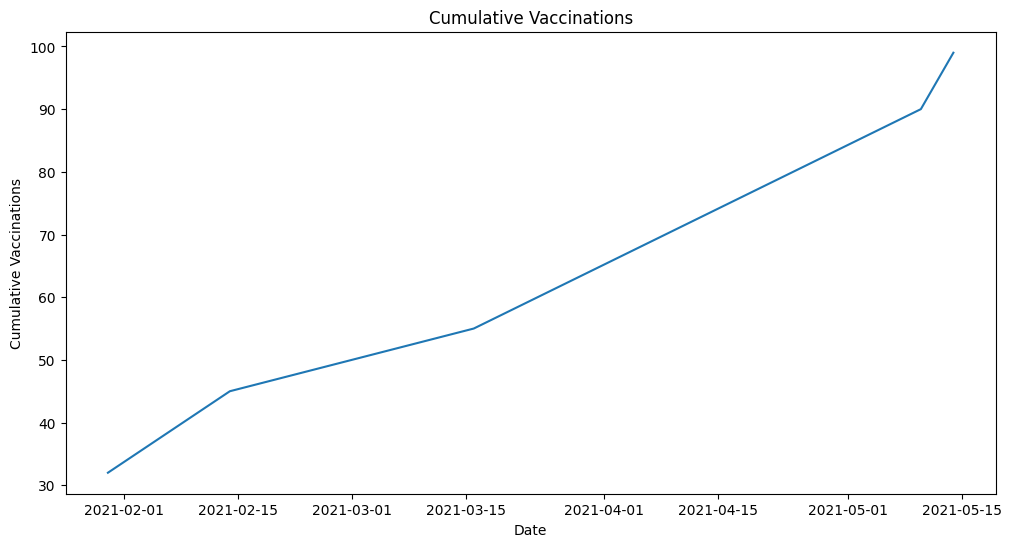

In [34]:
query9 = text("""
    SELECT date, COUNT(patientSsNo) as patients_vaccinated
    FROM VaccinePatients
    GROUP BY date
    ORDER BY date;
""")
df9 = pd.read_sql_query(query9, psql_conn)

fig = plt.figure()
fig.set_size_inches(12, 6)

df9['cumulative_vaccinations'] = df9['patients_vaccinated'].cumsum()
# df9.plot(x='date', y='cumulative_vaccinations')
plt.plot(df9['date'], df9['cumulative_vaccinations'])
plt.title('Cumulative Vaccinations')
plt.xlabel('Date')
plt.ylabel('Cumulative Vaccinations')
plt.show()


QUERY 10

In [35]:
query10 = text("""
WITH date_range AS (
    SELECT generate_series(
        '2021-05-05'::date, 
        '2021-05-15'::date, 
        '1 day'::interval
    ) AS date
), worker_shifts AS (
    SELECT s.weekday, s.station, s.worker
    FROM Shifts s
    WHERE s.worker = '19740919-7140'
), dates_and_shifts AS (
    SELECT date_range.date, worker_shifts.station, worker_shifts.worker
    FROM date_range
    JOIN worker_shifts ON trim(to_char(date_range.date, 'Day')) = worker_shifts.weekday
)
SELECT VaccinePatients.location as location, Patients.name as name, Patients.ssno as ssno, 'patient' as role
FROM VaccinePatients
JOIN dates_and_shifts ON VaccinePatients.date = dates_and_shifts.date
AND VaccinePatients.location = dates_and_shifts.station
JOIN Patients ON VaccinePatients.patientSsNo = Patients.ssno
UNION
SELECT Shifts.station as location, StaffMembers.name as name, StaffMembers.ssno as ssno, StaffMembers.role as role
FROM Shifts
JOIN StaffMembers ON Shifts.worker = StaffMembers.ssno
JOIN dates_and_shifts ON Shifts.weekday = trim(to_char(dates_and_shifts.date, 'Day')) 
AND Shifts.station = dates_and_shifts.station
""")
df10 = pd.read_sql_query(query10, psql_conn)
df10


,location,name,ssno,role
0,Tapiola Health Center,Loyal Hoeger,830820-576C,patient
1,Tapiola Health Center,Corine Hane,210318-737O,patient
2,Tapiola Health Center,Greg Schuppe,19771112-4048,nurse
3,Tapiola Health Center,Aliyah Harber,090416-443L,patient
4,Tapiola Health Center,Deon Hoppe,19740919-7140,nurse
5,Tapiola Health Center,Elenora Sawayn,130205-474D,patient
6,Tapiola Health Center,Ashley Konopelski,19910122-1693,nurse
7,Tapiola Health Center,Dr. Lamont Ferry,090226-5673,patient
8,Tapiola Health Center,Flossie Torp,871128-519R,patient
9,Tapiola Health Center,Sid Hahn,990622-5231,patient


In [36]:
# psql_conn.close()